# Лабораторная работа 2. Методы обучения нейронных сетей

### Содержание
1. [Работа с данными](#Работа-с-данными)
1. [Построение модели](#Построение-модели)
1. [Исследование гиперпараметров](#Исследование-гиперпараметров)

В данной лабораторной работе потребуется исследовать эффективность различных приемов и методов обучения нейронных сетей:
* количество нейронов скрытого слоя;
* количество эпох обучения;
* функции активации;
* регуляризация;
* инициализация весов;
* нормализация по мини-батчам;
* методы градиентного спуска;
* адаптивные методы градиентного спуска.

### Работа с данными

Исследовать эти приемы и методы предлагается на [MNIST](http://yann.lecun.com/exdb/mnist/) (Modified National Institute of Standards and Technology) – наборе черно-белых рукописных цифр размером 28x28 пикселей:

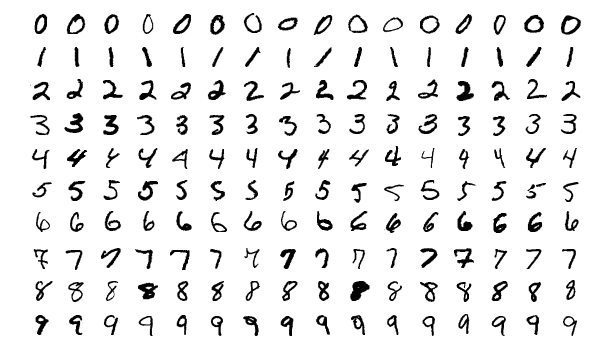

MNIST содержит 60 000 изображений для обучения и 10 000 изображений для тестирования.

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from time import time

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
torch.manual_seed(42)

---
Задаем гиперпараметры (некоторые из них нужно будет менять в процессе исследования):

In [4]:
input_size = 28 * 28 # 784
hidden_size = 500
num_classes = 10
num_epochs = 5
batch_size = 100
learning_rate = 0.001

---
Код работы с данными (загрузка, предобработка, сэмплирование) должен быть отделен от кода работы с моделями (создание, обучение, тестирование).  
PyTorch предоставляет два класса для работы с данными: `Dataset` и `DataLoader`:  
- класс [Dataset](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) позволяет загружать и хранить как предустановленные наборы данных (например, MNIST), так и свои собственные;
- класс [DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) позволяет осуществлять доступ к данным в процессе обучения.  

В PyTorch есть множество предустановленных наборов данных:
- [текстов](https://pytorch.org/text/stable/datasets.html);
- [изображений](https://pytorch.org/vision/stable/datasets.html);
- [аудио](https://pytorch.org/audio/stable/datasets.html).

Ниже приведен код загрузки MNIST:

In [5]:
train_dataset = torchvision.datasets.MNIST(root='data', 
                                           train=True, 
                                           transform=transforms.ToTensor(),  
                                           download=True)
train_dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [6]:
test_dataset = torchvision.datasets.MNIST(root='data', 
                                          train=False, 
                                          transform=transforms.ToTensor())
test_dataset

Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

---
Список всех классов в `Dataset`:

In [7]:
train_dataset.classes

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

In [8]:
test_dataset.classes

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

К примерам в `Dataset` можно обращаться по индексу. Выведем, например, метку самого первого примера:

In [9]:
print(f'Label of the first example is {train_dataset[0][1]}.')

Label of the first example is 5.


---
Цифры можно нарисовать:

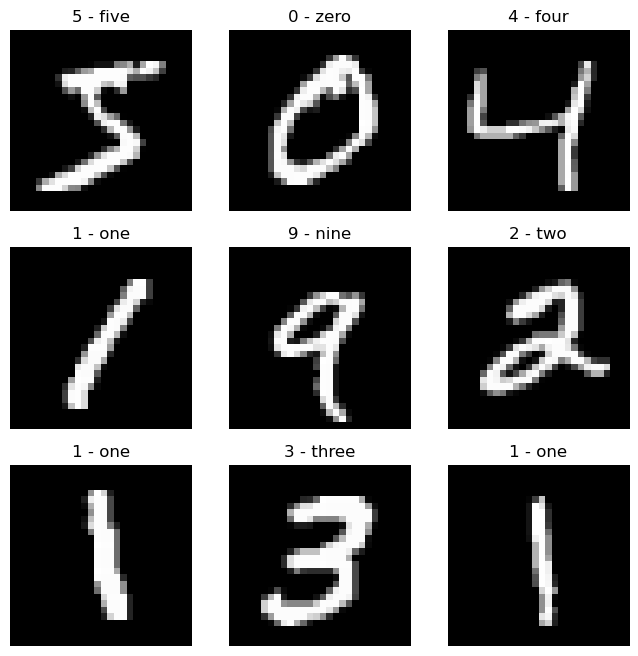

In [10]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3

for i in range(1, cols * rows + 1):
    img, label = train_dataset[i-1]
    
    figure.add_subplot(rows, cols, i)
    
    plt.title(train_dataset.classes[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
    
plt.show()

При загрузке мы применили [преобразование данных](https://pytorch.org/tutorials/beginner/basics/transforms_tutorial.html): `transform=transforms.ToTensor()` осуществляет преобразование чисел в тензоры и нормирует к диапазону [0, 1].  
Также можно применять преобразования к меткам (например, переводить индекс в *OneHot Encoding*), для этого служит параметр `target_transform`.

---
#### Терминология  
- *Батч (batch)* – подмножество обучающих данных, которое подается на сеть в процессе обучения. после чего веса сети обновляются.  
    - `batch_size = len(train_dataset)` – Vanilla Gradient Descent или Batch Gradient Descent
    - `batch_size = 1` – Stochastic Gradient Descent
    - `1 < batch_size < len(train_dataset)` – Mini-Batch Gradient Descent
- *Шаг (step)* – период обработки одного батча.  
- *Эпоха (epoch)* – период обработки всего обучающего множества; количество шагов в эпохе равно количеству батчей в обучающем множестве. 

---
Для подготовки данных для обучения служит класс `DataLoader`. Он позволяет случайным образом формировать мини-батчи и перемешивать данные перед каждой эпохой обучения.  
Зададим объекты `DataLoader` на основе MNIST:

In [11]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

In [12]:
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

---
По объектам `DataLoader` можно осуществлять итерацию; при этом на каждом шаге будет возвращаться подмножество размером `batch_size`:

In [13]:
print(f'Number of batches = {len(train_loader)}')

train_data, train_labels = next(iter(train_loader))
print(f'Size of the batch = {len(train_data)}')

print(f'Number of all the samples = {len(train_loader) * len(train_data)}')

Number of batches = 600
Size of the batch = 100
Number of all the samples = 60000


После того, как все батчи будут выданы (по окончании эпохи обучения), в случае, если `shuffle=True`, произойдет перемешивание данных и на следующей эпохе батчи будут уже другими.

### Построение модели

#### Задание.  
Опишите класс `NeuralNetwork` для распознавания MNIST: двухслойная нейронная сеть прямого распространения, количество нейронов скрытого слоя – `hidden_size`, функция активации скрытого слоя – `ReLU`. Выходной слой пусть остается линейным, без функции активации.

In [14]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.act = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        out = self.fc1(x)
        out = self.act(out)
        out = self.fc2(out)
        return out

#### Задание.  
Создайте объект класса `NeuralNetwork`, перенесите его на GPU.  
Задайте функцию потерь (например, `CrossEntropyLoss`) и любой оптимизатор.

In [15]:
model = NeuralNetwork(input_size, hidden_size, num_classes).to(device)

---
Напишем цикл обучения для нашей сети:

#### Задание.  
Постройте график зависимости потерь на мини-батче от шага обучения.

Epoch [1/5], Step [100/600], Loss: 2.2807
Epoch [1/5], Step [200/600], Loss: 2.2530
Epoch [1/5], Step [300/600], Loss: 2.2345
Epoch [1/5], Step [400/600], Loss: 2.2028
Epoch [1/5], Step [500/600], Loss: 2.1868
Epoch [1/5], Step [600/600], Loss: 2.1467
Epoch [2/5], Step [100/600], Loss: 2.1675
Epoch [2/5], Step [200/600], Loss: 2.1118
Epoch [2/5], Step [300/600], Loss: 2.0898
Epoch [2/5], Step [400/600], Loss: 2.0693
Epoch [2/5], Step [500/600], Loss: 2.0060
Epoch [2/5], Step [600/600], Loss: 1.9729
Epoch [3/5], Step [100/600], Loss: 2.0064
Epoch [3/5], Step [200/600], Loss: 1.9299
Epoch [3/5], Step [300/600], Loss: 1.9371
Epoch [3/5], Step [400/600], Loss: 1.9005
Epoch [3/5], Step [500/600], Loss: 1.8149
Epoch [3/5], Step [600/600], Loss: 1.7721
Epoch [4/5], Step [100/600], Loss: 1.7827
Epoch [4/5], Step [200/600], Loss: 1.7486
Epoch [4/5], Step [300/600], Loss: 1.6592
Epoch [4/5], Step [400/600], Loss: 1.6919
Epoch [4/5], Step [500/600], Loss: 1.6291
Epoch [4/5], Step [600/600], Loss:

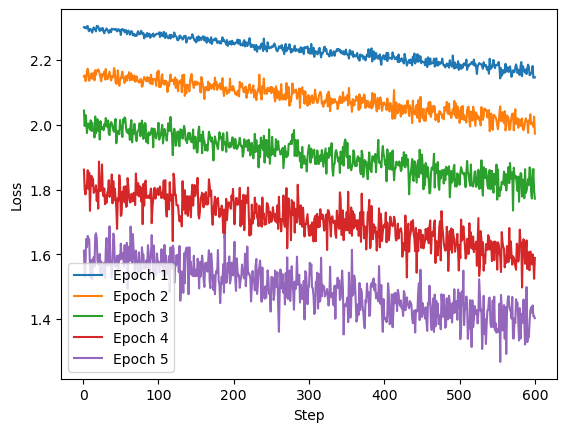

In [16]:
start_time = time()

total_step = len(train_loader)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    losses = []
    
    for i, (images, labels) in enumerate(train_loader):  
        # Move tensors to the configured device
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        losses.append(loss.item())
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_step}], Loss: {loss.item():.4f}')
    
    plt.plot(range(1, total_step + 1), losses, label=f'Epoch {epoch + 1}')
    plt.xlabel('Step')
    plt.ylabel('Loss')

plt.legend()
print(f'Time taken: {time() - start_time:.1f}')

---
Получим предсказания модели на тестовых данных:

In [17]:
with torch.no_grad():
    for images, labels in test_loader:
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        outputs = model(images)
        max_values, predicted = torch.max(outputs.data, 1)

print(f'last predict = {predicted[-1]}, true label = {labels[-1]}')

last predict = 6, true label = 6


#### Задание.  
Вычислите правильность (Accuracy) модели на тестовых данных.

In [18]:
with torch.no_grad():
    accuracies = []
    
    for images, labels in test_loader:
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        outputs = model(images)
        predicted = torch.argmax(outputs, 1)
        accuracies.append((predicted == labels).sum().item() / len(labels))

print(f'last predict = {predicted[-1]}, true label = {labels[-1]}')

last predict = 6, true label = 6


In [19]:
print(f'Accuracy on the test dataset: {np.mean(accuracies):.3f}')

Accuracy on the test dataset: 0.784


---
Сохраним полученную модель:

In [20]:
torch.save(model.state_dict(), 'model.ckpt')

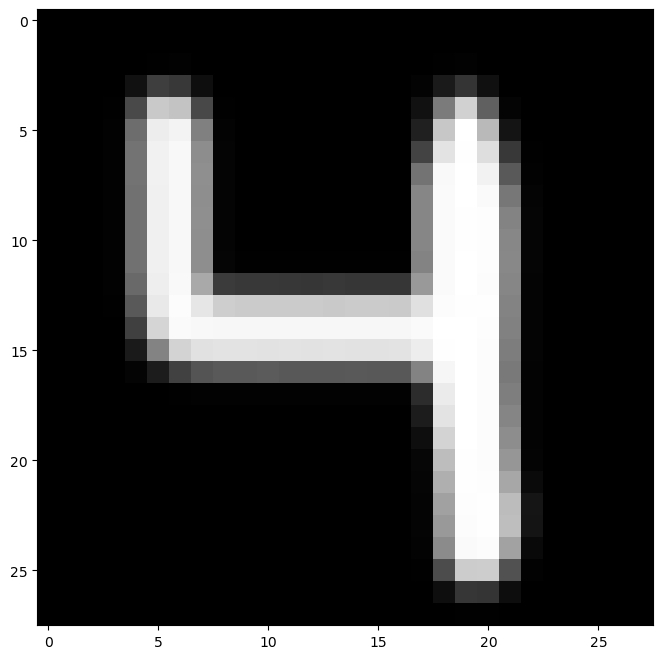

In [21]:
import cv2

img = cv2.imread('four.png', cv2.IMREAD_GRAYSCALE)
figure = plt.figure(figsize=(8, 8))
plt.imshow(img.squeeze(), cmap="gray")

plt.show()

In [22]:
img_tensor = torch.tensor(img, dtype=torch.float32).reshape(-1, 28*28).to(device)
img_tensor = nn.functional.normalize(img_tensor, dim=1)
model(img_tensor).argmax().item()

4

### Исследование гиперпараметров

#### Задание. 

Подберите гиперпараметры нейронной сети, обеспечивающие наилучшее качество классификации тестовых данных MNIST.  
Требуется исследовать следующие гиперпараметры:
* количество нейронов скрытого слоя – не менее 5 вариантов;
* количество эпох обучения – не менее 3 вариантов;
* функции активации – не менее 3 вариантов (симметричные и несимметричные);
* регуляризация – weight decay (L2) и dropout;
* инициализация весов (Xavier и Kaiming);
* нормализация по мини-батчам (наличие/отсутствие);
* методы градиентного спуска (SGD, momentum SGD, Nesterov SGD);
* адаптивные методы градиентного спуска (AdaGrad, AdaDelta, RMSProp, Adam, AdamW).

Необязательно выполнять полный перебор – можно осуществить жадный поиск.  

Результаты подбора вывести в удобном виде.  

Для всех вариантов градиентного спуска нарисовать графики процесса обучения.  


**Замечание**. Напомним, что в этом случае тестовый набор MNIST играет роль валидационного набора, так как подбор оптимальных значений гиперапараметров на тестовых данных может приводить к переобучению!

In [107]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes,
                 act_func="relu", dropout=0.0, include_mini_batch_norm=False, device="cuda:0"):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        
        if act_func == "relu":
            self.act = nn.ReLU()
        elif act_func == "sigmoid":
            self.act = nn.Sigmoid()
        elif act_func == "leaky_relu":
            self.act = nn.LeakyReLU()
        
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_size, num_classes)
        
        self.include_mini_batch_norm = include_mini_batch_norm
        self.device = device

    def forward(self, x):
        out = self.fc1(x)
        if self.include_mini_batch_norm:
            out = nn.BatchNorm1d(out.shape[1], device=self.device)(out)
        out = self.act(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out

In [108]:
class MNISTDataset(torch.utils.data.Dataset):
    def __init__(self, data, targets, transform=None):
        self.data = data
        self.targets = targets
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]
        label = self.targets[idx]
        return image, label

In [109]:
train_dataset = torchvision.datasets.MNIST(root='data',
                                           train=True,
                                           transform=transforms.ToTensor(),
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='data', 
                                          train=False, 
                                          transform=transforms.ToTensor())

In [110]:
import torch.nn.init as init

In [111]:
def train_model(model, train_dataset, val_dataset, batch_size, num_epochs, optimizer, weights_init=None):
    if weights_init == "xavier":
        for m in model.modules():
            if isinstance(m, nn.Linear):
                init.xavier_normal_(m.weight)
    elif weights_init == "kaiming":
        for m in model.modules():
            if isinstance(m, nn.Linear):
                init.kaiming_normal_(m.weight)
    
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                                  batch_size=batch_size,
                                                  shuffle=True)
    val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                                batch_size=batch_size,
                                                shuffle=False)
    
    model = model.to(device)
    loss_fn = nn.CrossEntropyLoss()
    
    for epoch in range(num_epochs):
        losses = []
    
        for i, (images, labels) in enumerate(train_loader):
            # Move tensors to the configured device
            images = images.reshape(-1, 28 * 28).to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            losses.append(loss.item())
    
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    with torch.no_grad():
        accuracies = []

        for images, labels in val_loader:
            images = images.reshape(-1, 28 * 28).to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            predicted = torch.argmax(outputs, 1)
            accuracies.append((predicted == labels).sum().item() / len(labels))
    
    print(f'Accuracy on the val dataset: {np.mean(accuracies):.3f}')
    return np.mean(accuracies)

In [112]:
from sklearn.model_selection import KFold

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

In [113]:
for number_of_hl_neurons in [10, 50, 100, 150, 200]:
    accuracies = []
    for train_index, val_index in kfold.split(train_dataset):
        val = MNISTDataset(train_dataset.data[val_index].to(dtype=torch.float32), train_dataset.targets[val_index], transforms.ToTensor())
        train = MNISTDataset(train_dataset.data[train_index].to(dtype=torch.float32), train_dataset.targets[train_index], transforms.ToTensor())
        
        model = NeuralNetwork(input_size, number_of_hl_neurons, num_classes)
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
        acc = train_model(model, train, val, 100, 5, optimizer)
        accuracies.append(acc)
    print(f'Number of hidden layer neurons: {number_of_hl_neurons}, mean accuracy: {np.mean(accuracies):.3f}')

Accuracy on the val dataset: 0.106
Accuracy on the val dataset: 0.089
Accuracy on the val dataset: 0.104
Accuracy on the val dataset: 0.104
Accuracy on the val dataset: 0.162
Number of hidden layer neurons: 10, mean accuracy: 0.113
Accuracy on the val dataset: 0.716
Accuracy on the val dataset: 0.723
Accuracy on the val dataset: 0.719
Accuracy on the val dataset: 0.729
Accuracy on the val dataset: 0.670
Number of hidden layer neurons: 50, mean accuracy: 0.711
Accuracy on the val dataset: 0.785
Accuracy on the val dataset: 0.776
Accuracy on the val dataset: 0.777
Accuracy on the val dataset: 0.791
Accuracy on the val dataset: 0.784
Number of hidden layer neurons: 100, mean accuracy: 0.783
Accuracy on the val dataset: 0.811
Accuracy on the val dataset: 0.806
Accuracy on the val dataset: 0.808
Accuracy on the val dataset: 0.806
Accuracy on the val dataset: 0.789
Number of hidden layer neurons: 150, mean accuracy: 0.804
Accuracy on the val dataset: 0.807
Accuracy on the val dataset: 0.799


In [118]:
hidden_size = 200

In [119]:
for number_of_epochs in [5, 10, 15, 20]:
    accuracies = []
    for train_index, val_index in kfold.split(train_dataset):
        val = MNISTDataset(train_dataset.data[val_index].to(dtype=torch.float32), train_dataset.targets[val_index], transforms.ToTensor())
        train = MNISTDataset(train_dataset.data[train_index].to(dtype=torch.float32), train_dataset.targets[train_index], transforms.ToTensor())
        
        model = NeuralNetwork(input_size, hidden_size, num_classes)
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
        acc = train_model(model, train, val, 100, number_of_epochs, optimizer)
        accuracies.append(acc)
    print(f'Number of epochs: {number_of_epochs}, mean accuracy: {np.mean(accuracies):.3f}')

Accuracy on the val dataset: 0.811
Accuracy on the val dataset: 0.808
Accuracy on the val dataset: 0.818
Accuracy on the val dataset: 0.810
Accuracy on the val dataset: 0.807
Number of epochs: 5, mean accuracy: 0.811
Accuracy on the val dataset: 0.852
Accuracy on the val dataset: 0.851
Accuracy on the val dataset: 0.850
Accuracy on the val dataset: 0.854
Accuracy on the val dataset: 0.852
Number of epochs: 10, mean accuracy: 0.852
Accuracy on the val dataset: 0.871
Accuracy on the val dataset: 0.869
Accuracy on the val dataset: 0.863
Accuracy on the val dataset: 0.870
Accuracy on the val dataset: 0.868
Number of epochs: 15, mean accuracy: 0.868
Accuracy on the val dataset: 0.890
Accuracy on the val dataset: 0.875
Accuracy on the val dataset: 0.874
Accuracy on the val dataset: 0.884
Accuracy on the val dataset: 0.881
Number of epochs: 20, mean accuracy: 0.881


In [122]:
number_of_epochs = 20

In [123]:
for activation_func in ["relu", "sigmoid", "leaky_relu"]:
    accuracies = []
    for train_index, val_index in kfold.split(train_dataset):
        val = MNISTDataset(train_dataset.data[val_index].to(dtype=torch.float32), train_dataset.targets[val_index], transforms.ToTensor())
        train = MNISTDataset(train_dataset.data[train_index].to(dtype=torch.float32), train_dataset.targets[train_index], transforms.ToTensor())
        
        model = NeuralNetwork(input_size, hidden_size, num_classes, activation_func)
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
        acc = train_model(model, train, val, 100, number_of_epochs, optimizer)
        accuracies.append(acc)
    print(f'Activation function: {activation_func}, mean accuracy: {np.mean(accuracies):.3f}')

Accuracy on the val dataset: 0.882
Accuracy on the val dataset: 0.878
Accuracy on the val dataset: 0.872
Accuracy on the val dataset: 0.880
Accuracy on the val dataset: 0.876
Activation function: relu, mean accuracy: 0.878
Accuracy on the val dataset: 0.388
Accuracy on the val dataset: 0.395
Accuracy on the val dataset: 0.395
Accuracy on the val dataset: 0.374
Accuracy on the val dataset: 0.404
Activation function: sigmoid, mean accuracy: 0.391
Accuracy on the val dataset: 0.881
Accuracy on the val dataset: 0.880
Accuracy on the val dataset: 0.875
Accuracy on the val dataset: 0.880
Accuracy on the val dataset: 0.877
Activation function: leaky_relu, mean accuracy: 0.879


In [126]:
activation_func = "leaky_relu"

In [127]:
for dropout in [0.0, 0.1, 0.2, 0.3]:
    accuracies = []
    for train_index, val_index in kfold.split(train_dataset):
        val = MNISTDataset(train_dataset.data[val_index].to(dtype=torch.float32), train_dataset.targets[val_index], transforms.ToTensor())
        train = MNISTDataset(train_dataset.data[train_index].to(dtype=torch.float32), train_dataset.targets[train_index], transforms.ToTensor())
        
        model = NeuralNetwork(input_size, hidden_size, num_classes, activation_func, dropout)
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
        acc = train_model(model, train, val, 100, number_of_epochs, optimizer)
        accuracies.append(acc)
    print(f'Dropout: {dropout}, mean accuracy: {np.mean(accuracies):.3f}')

Accuracy on the val dataset: 0.879
Accuracy on the val dataset: 0.882
Accuracy on the val dataset: 0.881
Accuracy on the val dataset: 0.877
Accuracy on the val dataset: 0.877
Dropout: 0.0, mean accuracy: 0.879
Accuracy on the val dataset: 0.856
Accuracy on the val dataset: 0.852
Accuracy on the val dataset: 0.861
Accuracy on the val dataset: 0.855
Accuracy on the val dataset: 0.853
Dropout: 0.1, mean accuracy: 0.855
Accuracy on the val dataset: 0.833
Accuracy on the val dataset: 0.832
Accuracy on the val dataset: 0.837
Accuracy on the val dataset: 0.841
Accuracy on the val dataset: 0.835
Dropout: 0.2, mean accuracy: 0.836
Accuracy on the val dataset: 0.814
Accuracy on the val dataset: 0.807
Accuracy on the val dataset: 0.813
Accuracy on the val dataset: 0.805
Accuracy on the val dataset: 0.808
Dropout: 0.3, mean accuracy: 0.809


In [135]:
for weights_init in ["xavier", "kaiming"]:
    accuracies = []
    for train_index, val_index in kfold.split(train_dataset):
        val = MNISTDataset(train_dataset.data[val_index].to(dtype=torch.float32), train_dataset.targets[val_index], transforms.ToTensor())
        train = MNISTDataset(train_dataset.data[train_index].to(dtype=torch.float32), train_dataset.targets[train_index], transforms.ToTensor())
        
        model = NeuralNetwork(input_size, hidden_size, num_classes, activation_func, 0.0, False)
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
        acc = train_model(model, train, val, 100, number_of_epochs, optimizer, weights_init)
        accuracies.append(acc)
    print(f'Weights initialization: {weights_init}, mean accuracy: {np.mean(accuracies):.3f}')

Accuracy on the val dataset: 0.098
Accuracy on the val dataset: 0.099
Accuracy on the val dataset: 0.099
Accuracy on the val dataset: 0.100
Accuracy on the val dataset: 0.098
Weights initialization: xavier, mean accuracy: 0.099
Accuracy on the val dataset: 0.098
Accuracy on the val dataset: 0.099
Accuracy on the val dataset: 0.099
Accuracy on the val dataset: 0.100
Accuracy on the val dataset: 0.098
Weights initialization: kaiming, mean accuracy: 0.099


In [138]:
for include_mini_batch_norm in [True, False]:
    accuracies = []
    for train_index, val_index in kfold.split(train_dataset):
        val = MNISTDataset(train_dataset.data[val_index].to(dtype=torch.float32), train_dataset.targets[val_index], transforms.ToTensor())
        train = MNISTDataset(train_dataset.data[train_index].to(dtype=torch.float32), train_dataset.targets[train_index], transforms.ToTensor())
        
        model = NeuralNetwork(input_size, hidden_size, num_classes, activation_func, 0.0, include_mini_batch_norm)
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
        acc = train_model(model, train, val, 100, number_of_epochs, optimizer)
        accuracies.append(acc)
    print(f'Mini batch normalization: {include_mini_batch_norm}, mean accuracy: {np.mean(accuracies):.3f}')

Accuracy on the val dataset: 0.975
Accuracy on the val dataset: 0.975
Accuracy on the val dataset: 0.974
Accuracy on the val dataset: 0.975
Accuracy on the val dataset: 0.976
Mini batch normalization: True, mean accuracy: 0.975
Accuracy on the val dataset: 0.098
Accuracy on the val dataset: 0.099
Accuracy on the val dataset: 0.099
Accuracy on the val dataset: 0.100
Accuracy on the val dataset: 0.098
Mini batch normalization: False, mean accuracy: 0.099


In [143]:
dropout = 0.0
include_mini_batch_norm = True

In [145]:
for optimizer_name in ["SGD", "SGD_momentum", "SGD_nesterov"]:
    accuracies = []
    for train_index, val_index in kfold.split(train_dataset):
        val = MNISTDataset(train_dataset.data[val_index].to(dtype=torch.float32), train_dataset.targets[val_index], transforms.ToTensor())
        train = MNISTDataset(train_dataset.data[train_index].to(dtype=torch.float32), train_dataset.targets[train_index], transforms.ToTensor())
        
        model = NeuralNetwork(input_size, hidden_size, num_classes, activation_func, dropout, include_mini_batch_norm)
        
        if optimizer_name == "SGD":
            optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
        elif optimizer_name == "SGD_momentum":
            optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
        elif optimizer_name == "SGD_nesterov":
            optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, nesterov=True)
        
        acc = train_model(model, train, val, 100, number_of_epochs, optimizer)
        accuracies.append(acc)
    print(f'Optimizer: {optimizer_name}, mean accuracy: {np.mean(accuracies):.3f}')

Accuracy on the val dataset: 0.977
Accuracy on the val dataset: 0.973
Accuracy on the val dataset: 0.974
Accuracy on the val dataset: 0.975
Accuracy on the val dataset: 0.975
Optimizer: SGD, mean accuracy: 0.975
Accuracy on the val dataset: 0.979
Accuracy on the val dataset: 0.977
Accuracy on the val dataset: 0.977
Accuracy on the val dataset: 0.979
Accuracy on the val dataset: 0.977
Optimizer: SGD_momentum, mean accuracy: 0.978
Accuracy on the val dataset: 0.979
Accuracy on the val dataset: 0.979
Accuracy on the val dataset: 0.978
Accuracy on the val dataset: 0.977
Accuracy on the val dataset: 0.977
Optimizer: SGD_nesterov, mean accuracy: 0.978


In [147]:
for optimizer_name in ["Adagrad", "Adadelta", "RMSprop", "Adam", "AdamW"]:
    accuracies = []
    for train_index, val_index in kfold.split(train_dataset):
        val = MNISTDataset(train_dataset.data[val_index].to(dtype=torch.float32), train_dataset.targets[val_index], transforms.ToTensor())
        train = MNISTDataset(train_dataset.data[train_index].to(dtype=torch.float32), train_dataset.targets[train_index], transforms.ToTensor())
        
        model = NeuralNetwork(input_size, hidden_size, num_classes, activation_func, dropout, include_mini_batch_norm).to(device)
        optimizer = getattr(torch.optim, optimizer_name)(model.parameters(), lr=learning_rate)
        acc = train_model(model, train, val, 100, number_of_epochs, optimizer)
        accuracies.append(acc)
    print(f'Optimizer: {optimizer_name}, mean accuracy: {np.mean(accuracies):.3f}')

Accuracy on the val dataset: 0.979
Accuracy on the val dataset: 0.976
Accuracy on the val dataset: 0.975
Accuracy on the val dataset: 0.977
Accuracy on the val dataset: 0.976
Optimizer: Adagrad, mean accuracy: 0.977
Accuracy on the val dataset: 0.975
Accuracy on the val dataset: 0.973
Accuracy on the val dataset: 0.971
Accuracy on the val dataset: 0.973
Accuracy on the val dataset: 0.973
Optimizer: Adadelta, mean accuracy: 0.973
Accuracy on the val dataset: 0.969
Accuracy on the val dataset: 0.967
Accuracy on the val dataset: 0.970
Accuracy on the val dataset: 0.967
Accuracy on the val dataset: 0.967
Optimizer: RMSprop, mean accuracy: 0.968
Accuracy on the val dataset: 0.973
Accuracy on the val dataset: 0.969
Accuracy on the val dataset: 0.970
Accuracy on the val dataset: 0.967
Accuracy on the val dataset: 0.967
Optimizer: Adam, mean accuracy: 0.969
Accuracy on the val dataset: 0.947
Accuracy on the val dataset: 0.948
Accuracy on the val dataset: 0.937
Accuracy on the val dataset: 0.95

In [150]:
for learning_rate in [0.1, 0.05, 0.01, 0.005, 0.001, 0.0001, 0.00001]:
    accuracies = []
    for train_index, val_index in kfold.split(train_dataset):
        val = MNISTDataset(train_dataset.data[val_index].to(dtype=torch.float32), train_dataset.targets[val_index], transforms.ToTensor())
        train = MNISTDataset(train_dataset.data[train_index].to(dtype=torch.float32), train_dataset.targets[train_index], transforms.ToTensor())
        
        model = NeuralNetwork(input_size, hidden_size, num_classes, activation_func, dropout, include_mini_batch_norm).to(device)
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, nesterov=True)
        acc = train_model(model, train, val, 100, number_of_epochs, optimizer)
        accuracies.append(acc)
    print(f'Learning rate: {learning_rate}, mean accuracy: {np.mean(accuracies):.3f}')

Accuracy on the val dataset: 0.980
Accuracy on the val dataset: 0.978
Accuracy on the val dataset: 0.978
Accuracy on the val dataset: 0.977
Accuracy on the val dataset: 0.976
Learning rate: 0.1, mean accuracy: 0.978
Accuracy on the val dataset: 0.977
Accuracy on the val dataset: 0.976
Accuracy on the val dataset: 0.977
Accuracy on the val dataset: 0.978
Accuracy on the val dataset: 0.977
Learning rate: 0.05, mean accuracy: 0.977
Accuracy on the val dataset: 0.976
Accuracy on the val dataset: 0.975
Accuracy on the val dataset: 0.973
Accuracy on the val dataset: 0.975
Accuracy on the val dataset: 0.974
Learning rate: 0.01, mean accuracy: 0.975
Accuracy on the val dataset: 0.974
Accuracy on the val dataset: 0.973
Accuracy on the val dataset: 0.971
Accuracy on the val dataset: 0.973
Accuracy on the val dataset: 0.974
Learning rate: 0.005, mean accuracy: 0.973
Accuracy on the val dataset: 0.966
Accuracy on the val dataset: 0.963
Accuracy on the val dataset: 0.963
Accuracy on the val dataset

In [152]:
learning_rate = 0.1

In [153]:
for momentum in [0.1, 0.3, 0.5, 0.7, 0.9]:
    accuracies = []
    for train_index, val_index in kfold.split(train_dataset):
        val = MNISTDataset(train_dataset.data[val_index].to(dtype=torch.float32), train_dataset.targets[val_index], transforms.ToTensor())
        train = MNISTDataset(train_dataset.data[train_index].to(dtype=torch.float32), train_dataset.targets[train_index], transforms.ToTensor())
        
        model = NeuralNetwork(input_size, hidden_size, num_classes, activation_func, dropout, include_mini_batch_norm).to(device)
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, nesterov=True)
        acc = train_model(model, train, val, 100, number_of_epochs, optimizer)
        accuracies.append(acc)
    print(f'Momentum: {momentum}, mean accuracy: {np.mean(accuracies):.3f}')

Accuracy on the val dataset: 0.976
Accuracy on the val dataset: 0.974
Accuracy on the val dataset: 0.973
Accuracy on the val dataset: 0.975
Accuracy on the val dataset: 0.975
Momentum: 0.1, mean accuracy: 0.974
Accuracy on the val dataset: 0.976
Accuracy on the val dataset: 0.976
Accuracy on the val dataset: 0.973
Accuracy on the val dataset: 0.976
Accuracy on the val dataset: 0.976
Momentum: 0.3, mean accuracy: 0.975
Accuracy on the val dataset: 0.977
Accuracy on the val dataset: 0.976
Accuracy on the val dataset: 0.976
Accuracy on the val dataset: 0.977
Accuracy on the val dataset: 0.976
Momentum: 0.5, mean accuracy: 0.976
Accuracy on the val dataset: 0.978
Accuracy on the val dataset: 0.976
Accuracy on the val dataset: 0.978
Accuracy on the val dataset: 0.978
Accuracy on the val dataset: 0.976
Momentum: 0.7, mean accuracy: 0.977
Accuracy on the val dataset: 0.981
Accuracy on the val dataset: 0.978
Accuracy on the val dataset: 0.979
Accuracy on the val dataset: 0.977
Accuracy on the 

In [154]:
momentum = 0.9

In [155]:
model = NeuralNetwork(input_size, hidden_size, num_classes, activation_func, dropout, include_mini_batch_norm)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, nesterov=True)
train_model(model, train_dataset, test_dataset, 100, number_of_epochs, optimizer)

Accuracy on the val dataset: 0.979


0.9791

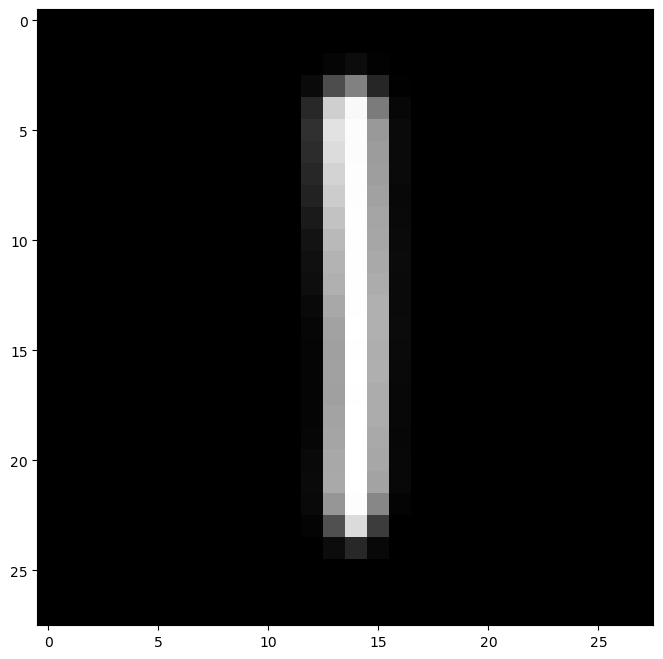

In [186]:
img = cv2.imread('one.png', cv2.IMREAD_GRAYSCALE)
figure = plt.figure(figsize=(8, 8))
plt.imshow(img.squeeze(), cmap="gray")

plt.show()

In [187]:
with torch.no_grad():
    img_tensor = torch.tensor(img, dtype=torch.float32).reshape(-1, 28 * 28).to(device)
    img_tensor = img_tensor[None, :]
    print(model(img_tensor).argmax().item())

1


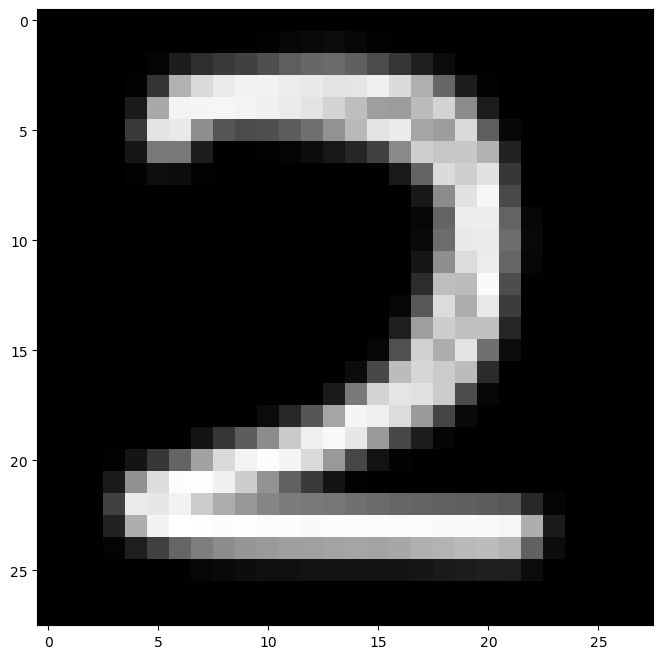

In [188]:
img = cv2.imread('two.png', cv2.IMREAD_GRAYSCALE)
figure = plt.figure(figsize=(8, 8))
plt.imshow(img.squeeze(), cmap="gray")

plt.show()

In [189]:
with torch.no_grad():
    img_tensor = torch.tensor(img, dtype=torch.float32).reshape(-1, 28 * 28).to(device)
    img_tensor = img_tensor[None, :]
    print(model(img_tensor).argmax().item())

3


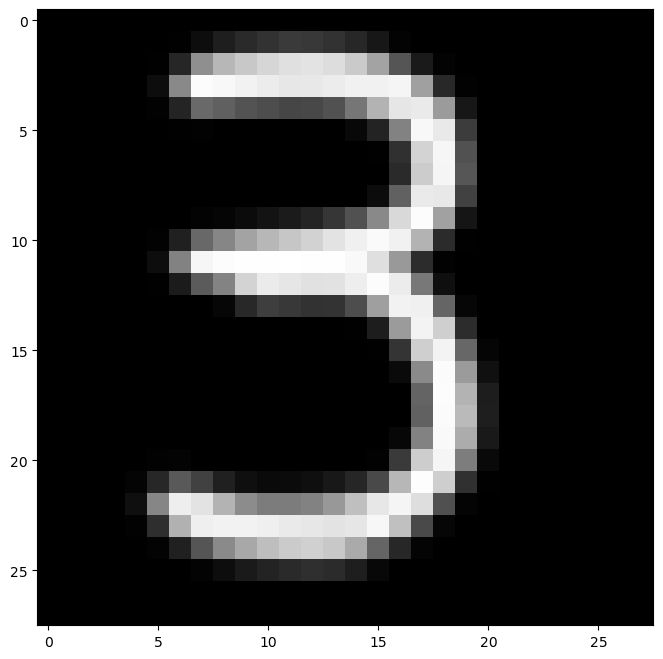

In [190]:
img = cv2.imread('three.png', cv2.IMREAD_GRAYSCALE)
figure = plt.figure(figsize=(8, 8))
plt.imshow(img.squeeze(), cmap="gray")

plt.show()

In [191]:
with torch.no_grad():
    img_tensor = torch.tensor(img, dtype=torch.float32).reshape(-1, 28 * 28).to(device)
    img_tensor = img_tensor[None, :]
    print(model(img_tensor).argmax().item())

3


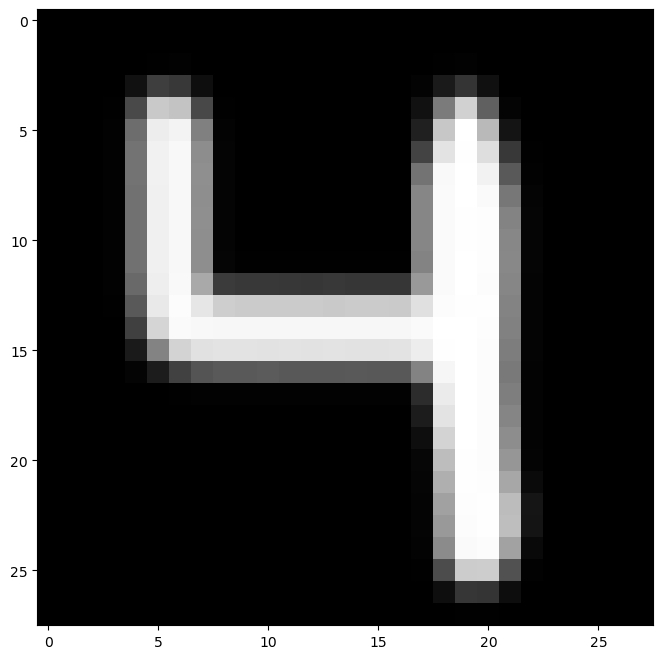

In [192]:
img = cv2.imread('four.png', cv2.IMREAD_GRAYSCALE)
figure = plt.figure(figsize=(8, 8))
plt.imshow(img.squeeze(), cmap="gray")

plt.show()

In [193]:
with torch.no_grad():
    img_tensor = torch.tensor(img, dtype=torch.float32).reshape(-1, 28 * 28).to(device)
    img_tensor = img_tensor[None, :]
    print(model(img_tensor).argmax().item())

4


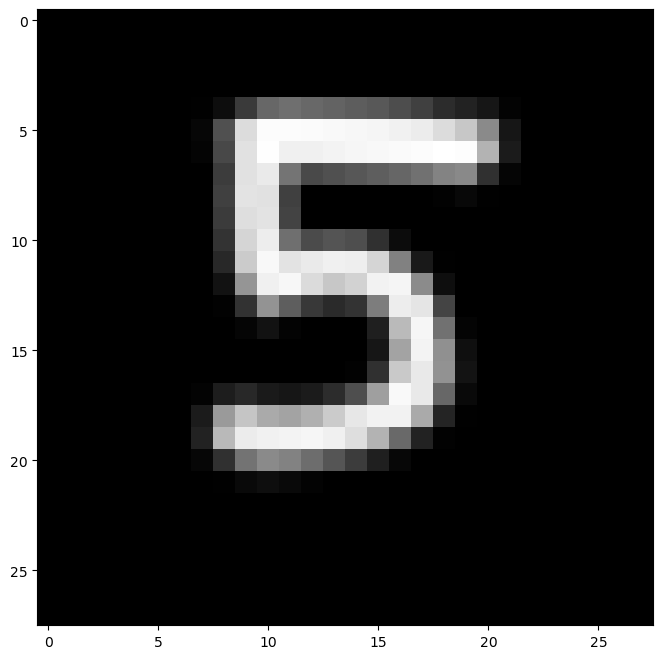

In [194]:
img = cv2.imread('five.png', cv2.IMREAD_GRAYSCALE)
figure = plt.figure(figsize=(8, 8))
plt.imshow(img.squeeze(), cmap="gray")

plt.show()

In [195]:
with torch.no_grad():
    img_tensor = torch.tensor(img, dtype=torch.float32).reshape(-1, 28 * 28).to(device)
    img_tensor = img_tensor[None, :]
    print(model(img_tensor).argmax().item())

9


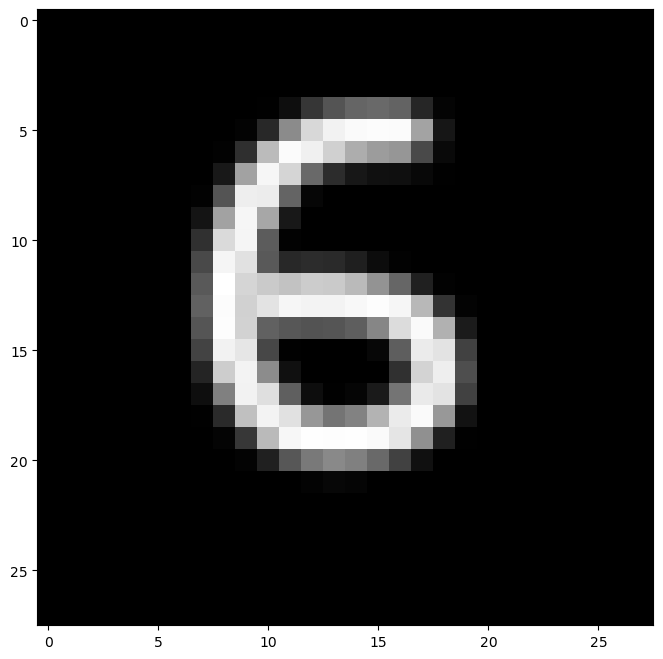

In [196]:
img = cv2.imread('six.png', cv2.IMREAD_GRAYSCALE)
figure = plt.figure(figsize=(8, 8))
plt.imshow(img.squeeze(), cmap="gray")

plt.show()

In [197]:
with torch.no_grad():
    img_tensor = torch.tensor(img, dtype=torch.float32).reshape(-1, 28 * 28).to(device)
    img_tensor = img_tensor[None, :]
    print(model(img_tensor).argmax().item())

8


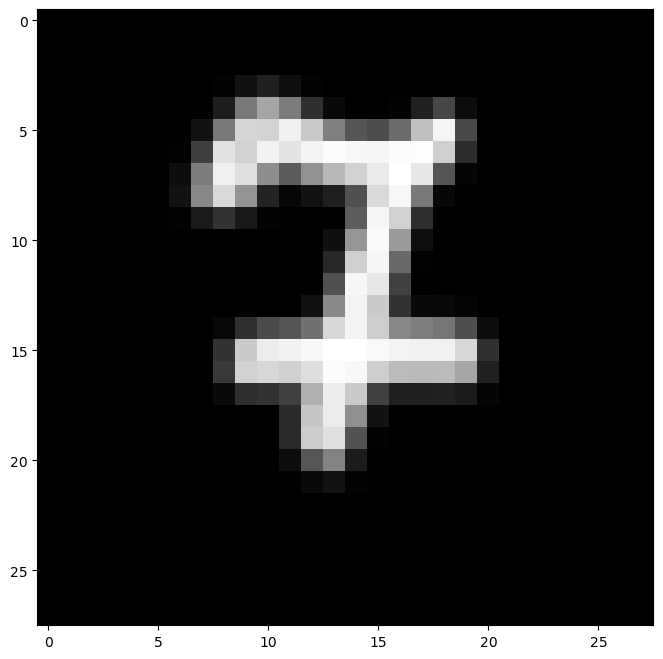

In [198]:
img = cv2.imread('seven.png', cv2.IMREAD_GRAYSCALE)
figure = plt.figure(figsize=(8, 8))
plt.imshow(img.squeeze(), cmap="gray")

plt.show()

In [199]:
with torch.no_grad():
    img_tensor = torch.tensor(img, dtype=torch.float32).reshape(-1, 28 * 28).to(device)
    img_tensor = img_tensor[None, :]
    print(model(img_tensor).argmax().item())

7


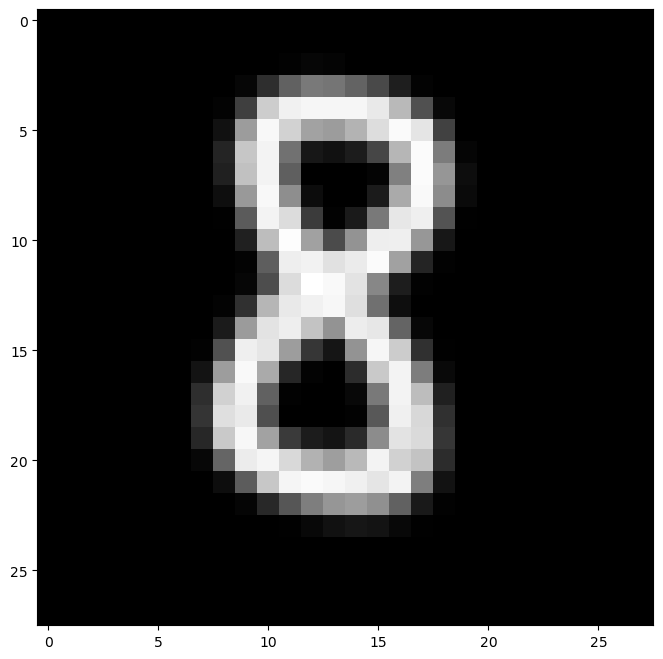

In [200]:
img = cv2.imread('eight.png', cv2.IMREAD_GRAYSCALE)
figure = plt.figure(figsize=(8, 8))
plt.imshow(img.squeeze(), cmap="gray")

plt.show()

In [201]:
with torch.no_grad():
    img_tensor = torch.tensor(img, dtype=torch.float32).reshape(-1, 28 * 28).to(device)
    img_tensor = img_tensor[None, :]
    print(model(img_tensor).argmax().item())

8


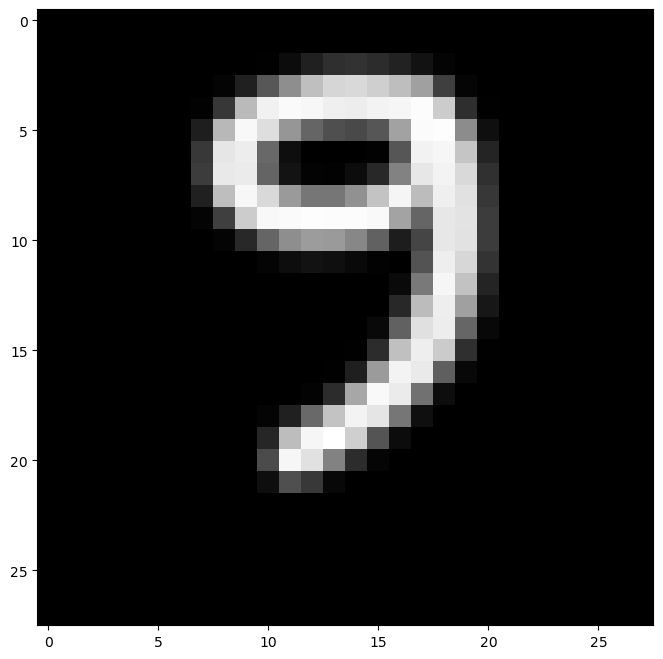

In [204]:
img = cv2.imread('nine.png', cv2.IMREAD_GRAYSCALE)
figure = plt.figure(figsize=(8, 8))
plt.imshow(img.squeeze(), cmap="gray")

plt.show()

In [205]:
with torch.no_grad():
    img_tensor = torch.tensor(img, dtype=torch.float32).reshape(-1, 28 * 28).to(device)
    img_tensor = img_tensor[None, :]
    print(model(img_tensor).argmax().item())

3


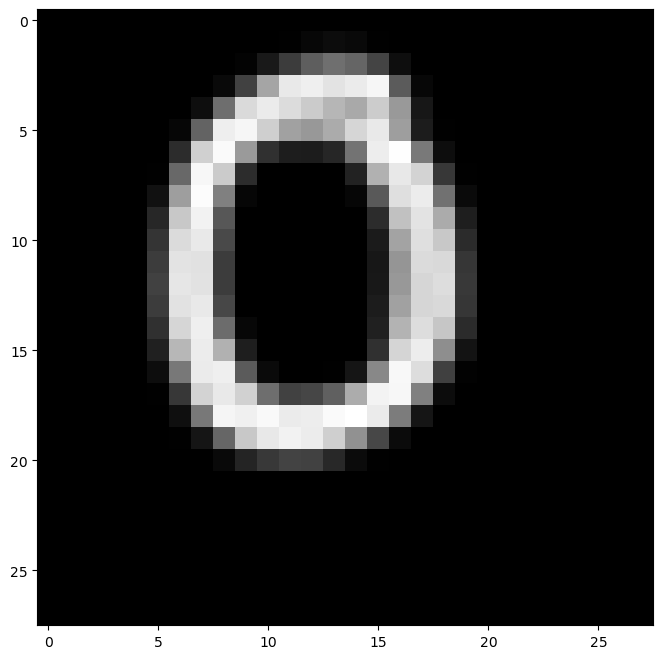

In [206]:
img = cv2.imread('zero.png', cv2.IMREAD_GRAYSCALE)
figure = plt.figure(figsize=(8, 8))
plt.imshow(img.squeeze(), cmap="gray")

plt.show()

In [208]:
with torch.no_grad():
    img_tensor = torch.tensor(img, dtype=torch.float32).reshape(-1, 28 * 28).to(device)
    img_tensor = img_tensor[None, :]
    print(model(img_tensor).argmax().item())

0


In [209]:
#Итог: точность на тестовом наборе данных MNIST составила 0.9791, однако на моих собственных изображениях точность оказалась ниже, а именно 6 из 10 изображений были распознаны верно (0.6).

#### Задания (факультативные).
1. Прочитать параграф 3.6 в учебнике С. Николенко и др. (стр. 123–135) и воспроизвести рассмотренные там нейронные сети на TensorFlow.
1. Воспроизвести пример на Keras на стр. 147–149.
1. Воспроизвести пример на TensorFlow на стр. 158–159.